In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [31]:
df = pd.read_csv('/Users/harshitgupta/Desktop/vs /VS-Data-Den/model_training/model_dataset.csv',index_col='YEARWEEK',parse_dates=True)
# df.index.freq='MS'

In [32]:
df.head()

,PTNR_REGIONAL_MASTER_CD,TOTAL_SALES
YEARWEEK,,
2019-12-02,0.0,28994.45
2019-12-09,0.0,127699.87
2019-12-16,0.0,102609.00
2020-06-01,0.0,37745.66
2020-06-08,0.0,72885.09


In [33]:
df['PTNR_REGIONAL_MASTER_CD'] = df['PTNR_REGIONAL_MASTER_CD'].astype('category')

<Axes: xlabel='YEARWEEK'>

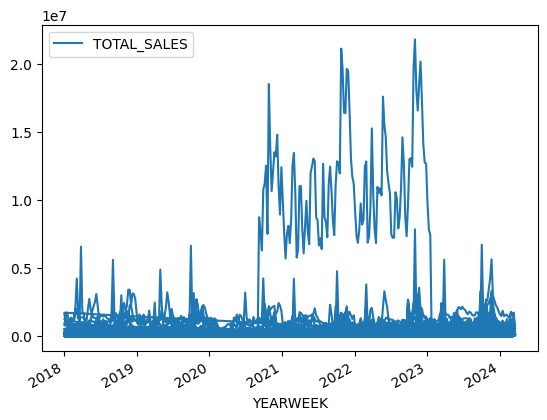

In [34]:
df.plot()

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [36]:
ANNUAL_PERIOD = 365*24
mult_decomp = seasonal_decompose(df['TOTAL_SALES'])
mult_decomp.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

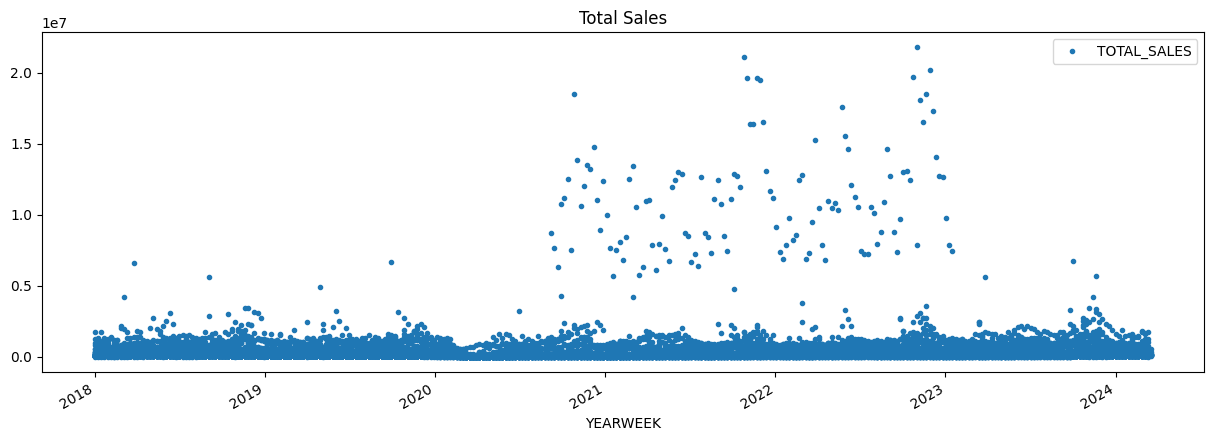

In [ ]:

color_pal = sns.color_palette()
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Total Sales')
plt.show()

In [ ]:
df['YEAR'] = df.index.year
df['MONTH'] = df.index.month
df['DAY'] = df.index.day
df['DAY_OF_WEEK'] = df.index.dayofweek
df['WEEK_OF_YEAR'] = df.index.isocalendar().week


In [ ]:
train = df.iloc[:int(0.6*len(df))]
test = df.iloc[int(0.6*len(df)):]


In [ ]:
features = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'WEEK_OF_YEAR', 'PTNR_REGIONAL_MASTER_CD']
target = 'TOTAL_SALES'

In [ ]:
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [ ]:
X_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,WEEK_OF_YEAR,PTNR_REGIONAL_MASTER_CD
YEARWEEK,,,,,,
2019-12-02,2019,12,2,0,49,0.0
2019-12-09,2019,12,9,0,50,0.0
2019-12-16,2019,12,16,0,51,0.0
2020-06-01,2020,6,1,0,23,0.0
2020-06-08,2020,6,8,0,24,0.0


In [ ]:
y_test.tail()

YEARWEEK
2024-02-05     96965.71
2024-02-12     89132.97
2024-02-19    113202.00
2024-02-26    129128.79
2024-03-04    139288.05
Name: TOTAL_SALES, dtype: float64

In [ ]:
xg_reg = lgb.LGBMRegressor(learning_rate=1)
xg_reg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 9823, number of used features: 5
[LightGBM] [Info] Start training from score 406430.854283


LGBMRegressor()

In [ ]:
# model = xgb.XGBRegressor(X_train, y_train, X_test, y_test)

In [ ]:
# results = model.fit()

In [ ]:
y_pred_train = xg_reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

In [ ]:
y_pred_test = xg_reg.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [ ]:
train_rmse , test_rmse

(291127.5245928012, 280596.28342550946)

In [ ]:
predictions_xgb = pd.DataFrame({'Date': test.index, 'Actual_Sales': y_test, 'Predicted_Sales': y_pred_test, 'PTNR_REGIONAL_MASTER_CD': X_test['PTNR_REGIONAL_MASTER_CD']})


In [ ]:
predictions_agg_xgb = predictions_xgb.groupby('PTNR_REGIONAL_MASTER_CD').agg({'Actual_Sales': 'sum', 'Predicted_Sales': 'sum'}).reset_index()
print(predictions_agg_xgb)

   PTNR_REGIONAL_MASTER_CD  Actual_Sales  Predicted_Sales
0                      0.0          0.00     0.000000e+00
1               50000001.0          0.00     0.000000e+00
2               50000002.0          0.00     0.000000e+00
3               50000004.0          0.00     0.000000e+00
4               50000006.0          0.00     0.000000e+00
..                     ...           ...              ...
64              50001007.0    7374063.26     2.992060e+06
65              50001066.0    2663885.90     2.432976e+06
66              50001126.0    1937086.85     1.701105e+06
67              50001136.0    8317281.33     6.000282e+06
68              50001145.0   10375274.24     2.184159e+06

[69 rows x 3 columns]


/var/folders/_p/ljb0l43112vc95swz8nhgv340000gn/T/ipykernel_64417/3723343204.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictions_agg_xgb = predictions_xgb.groupby('PTNR_REGIONAL_MASTER_CD').agg({'Actual_Sales': 'sum', 'Predicted_Sales': 'sum'}).reset_index()


In [ ]:
# test['prediction'] = xg_reg.predict(X_test)

# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# df.tail(2)

In [ ]:

# ax = df[['TOTAL_SALES']].plot(figsize=(15, 5))

# df['prediction'].plot(ax=ax, style='.')
# plt.legend(['Ground Truth Data', 'Predictions'])
# ax.set_title('Actual Past Data and Prediction')
# plt.show()

In [ ]:
combined_data = pd.concat([train, test])


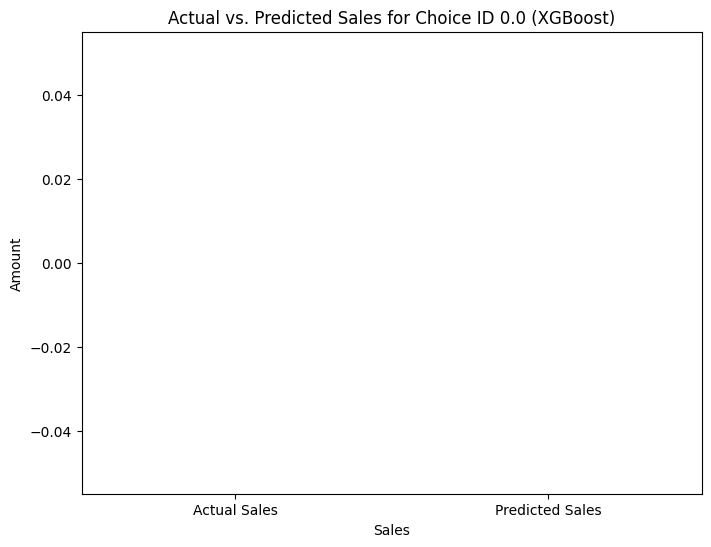

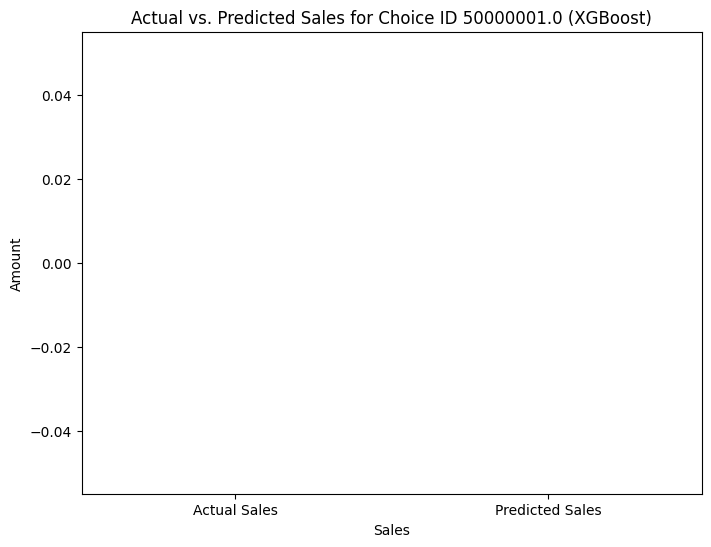

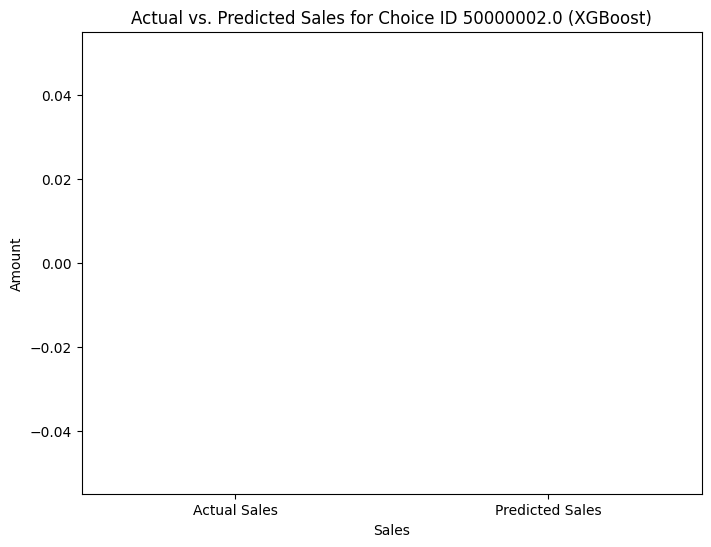

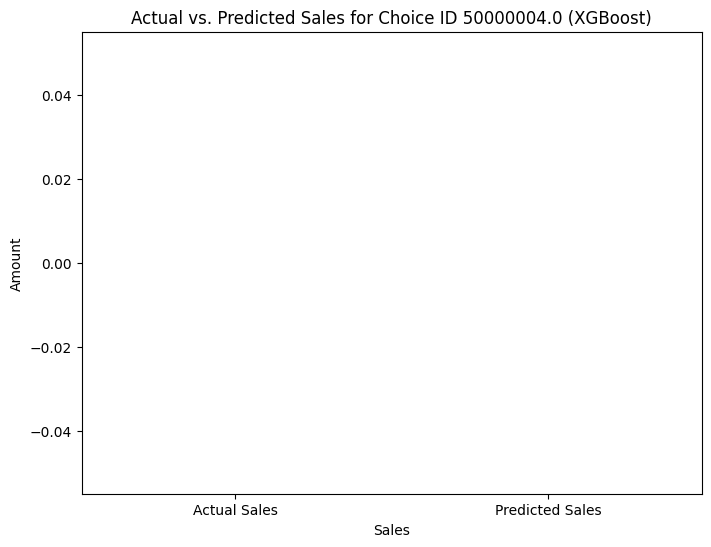

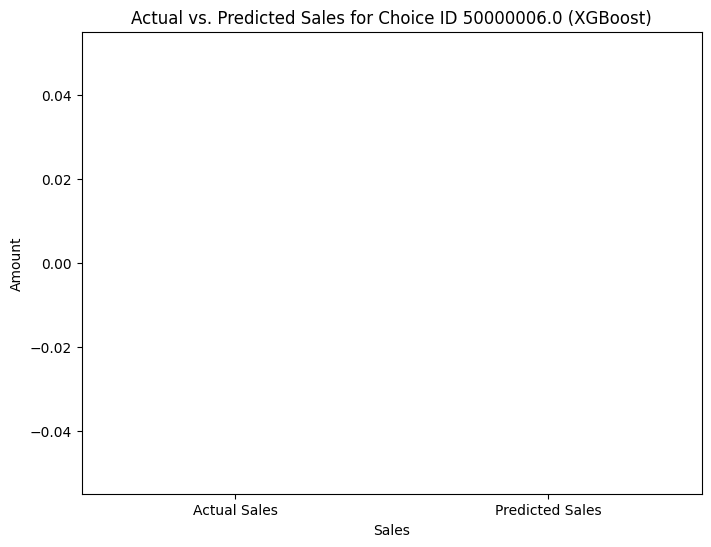

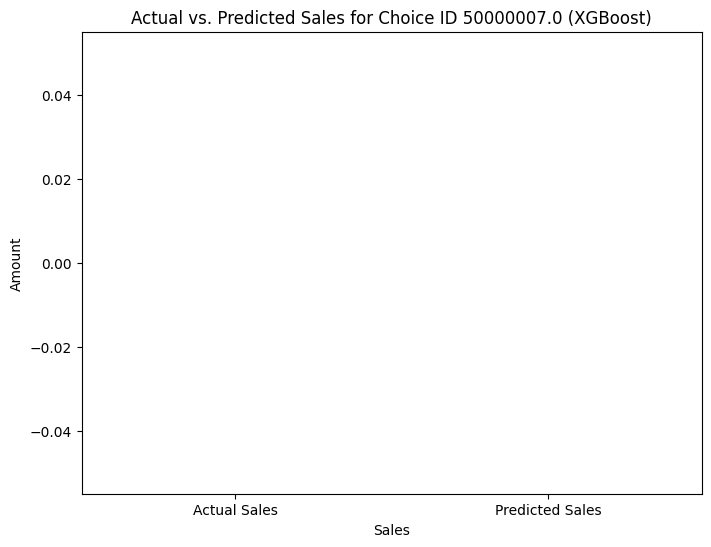

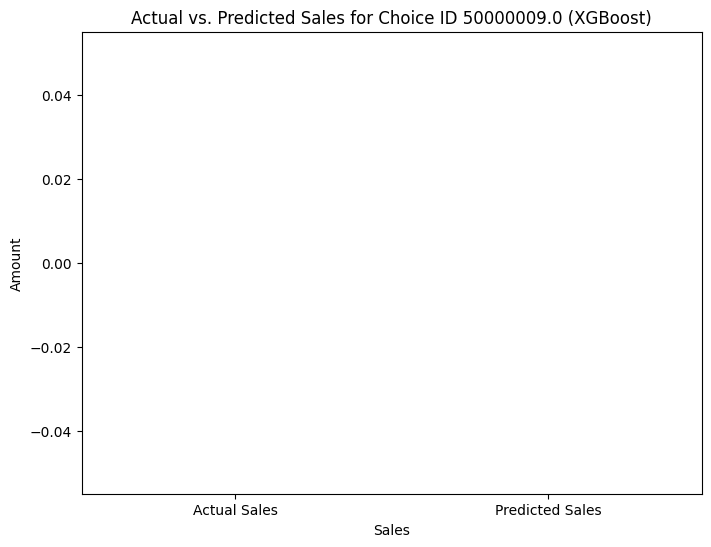

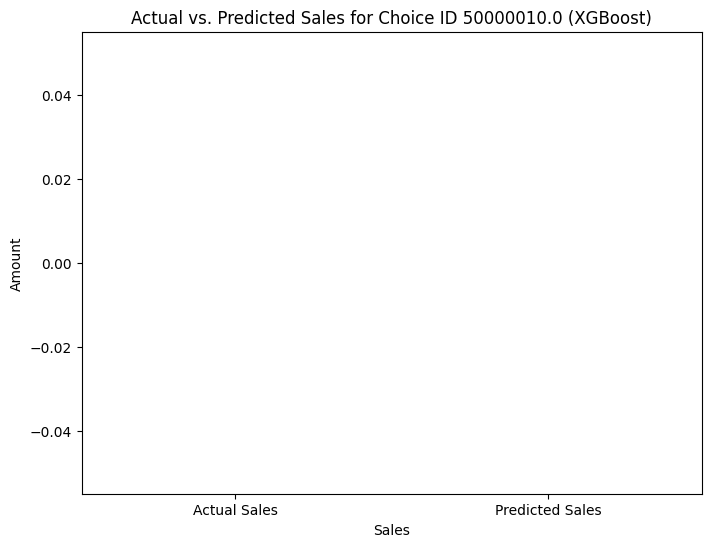

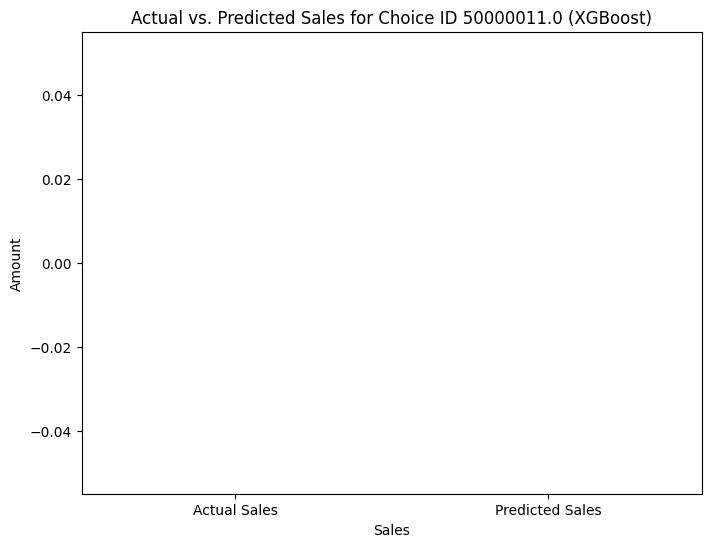

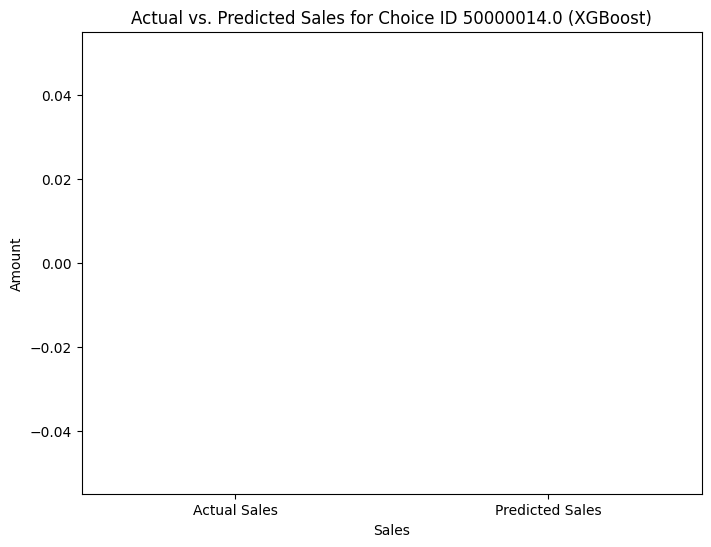

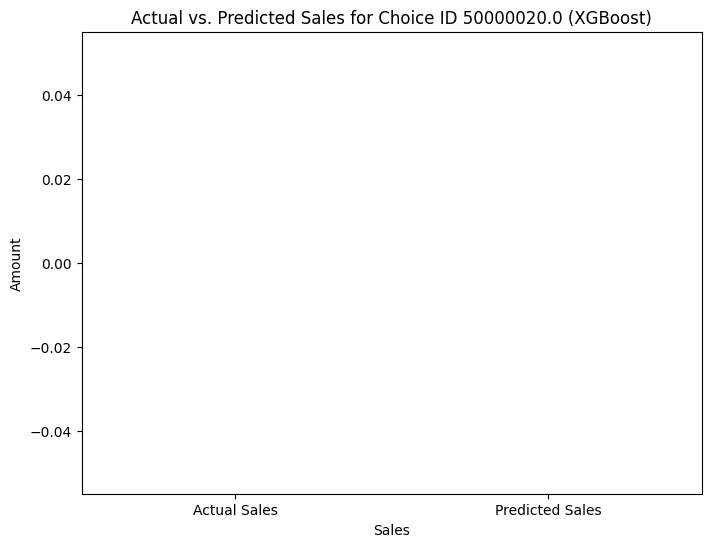

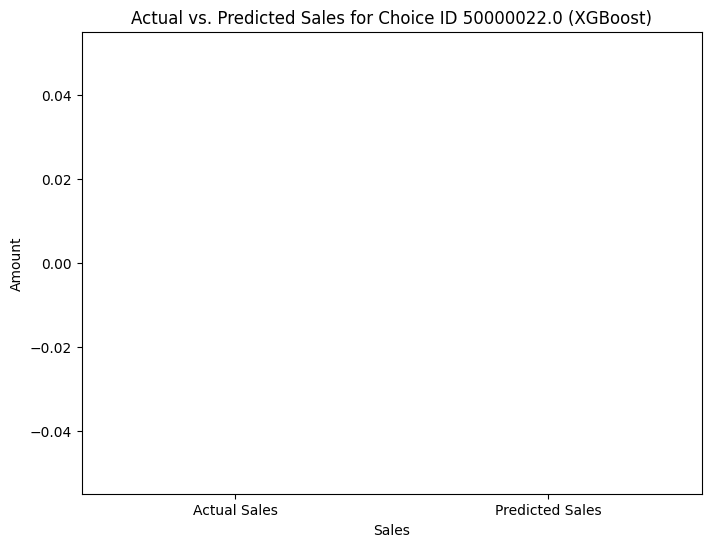

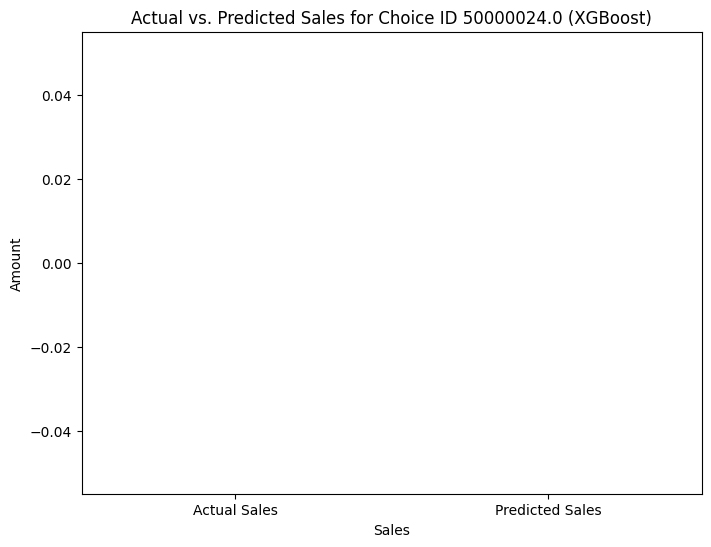

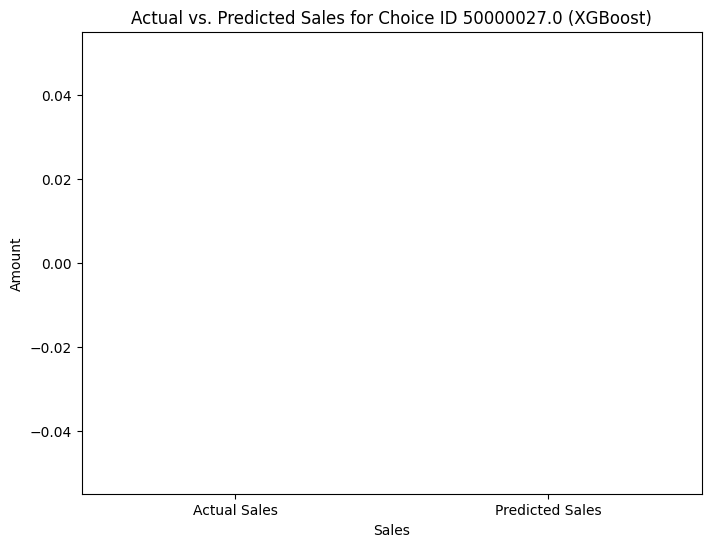

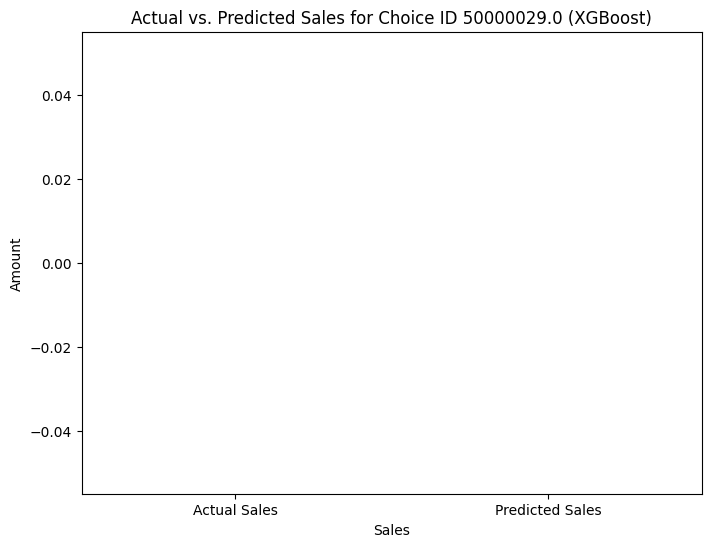

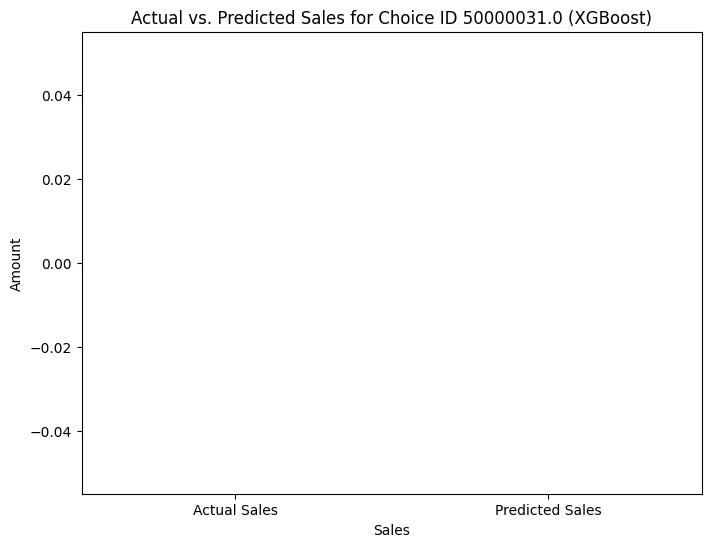

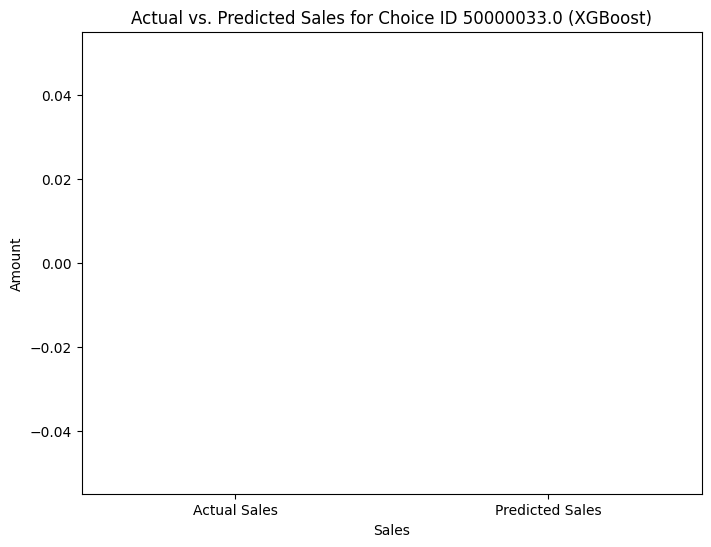

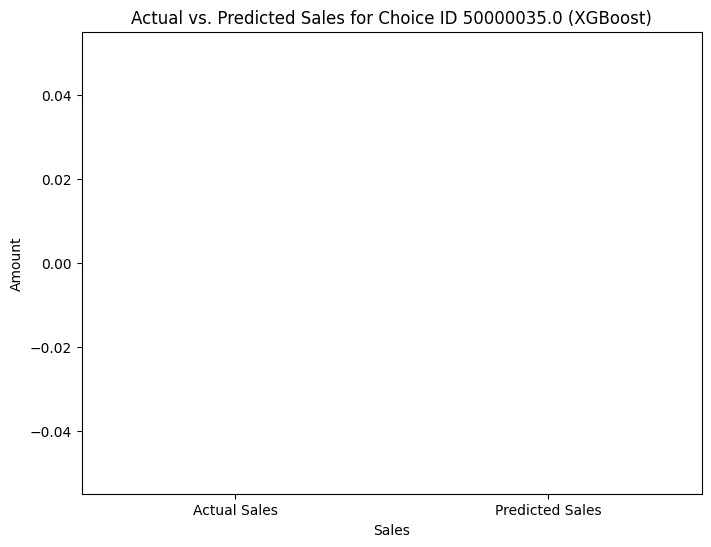

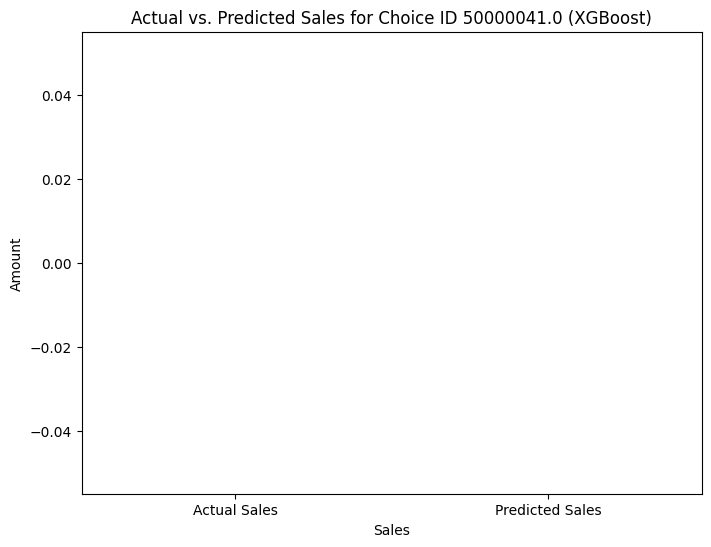

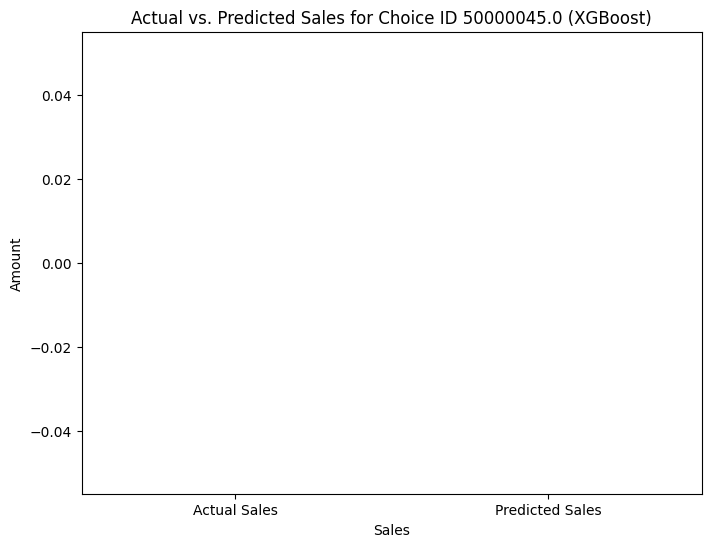

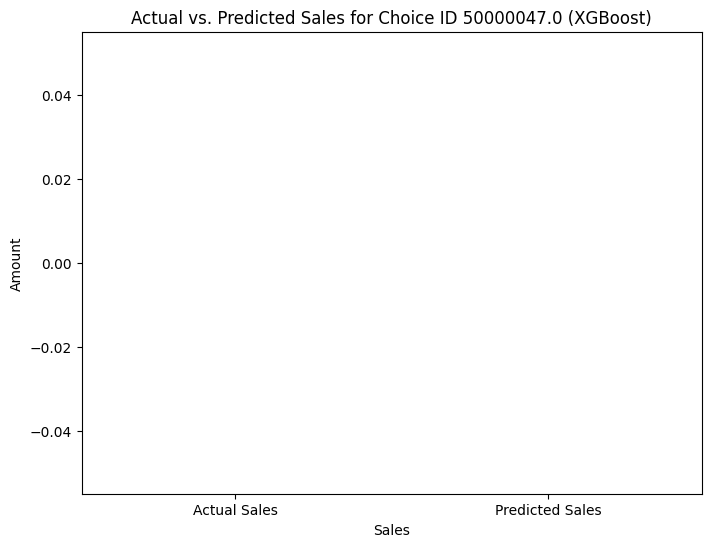

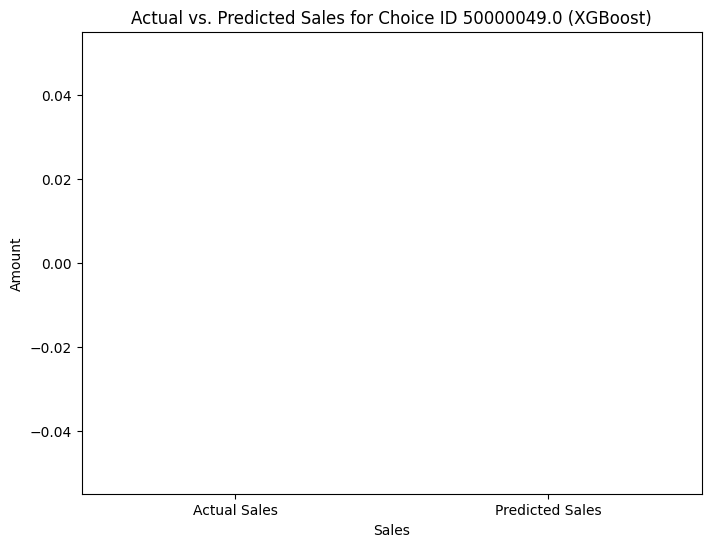

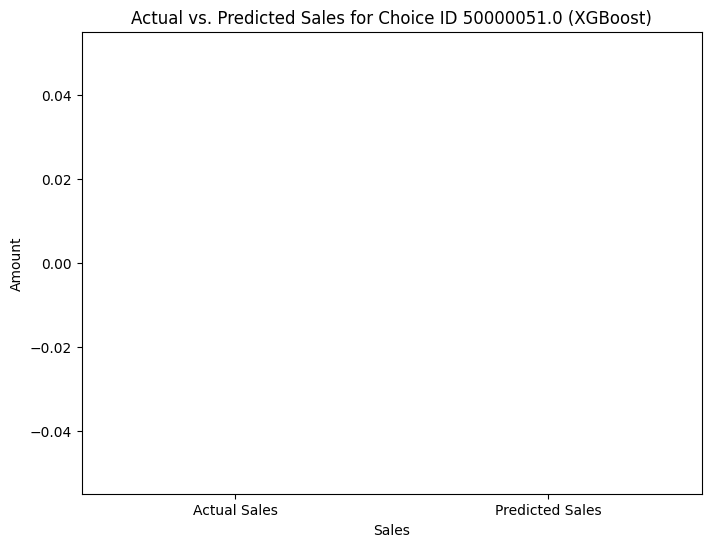

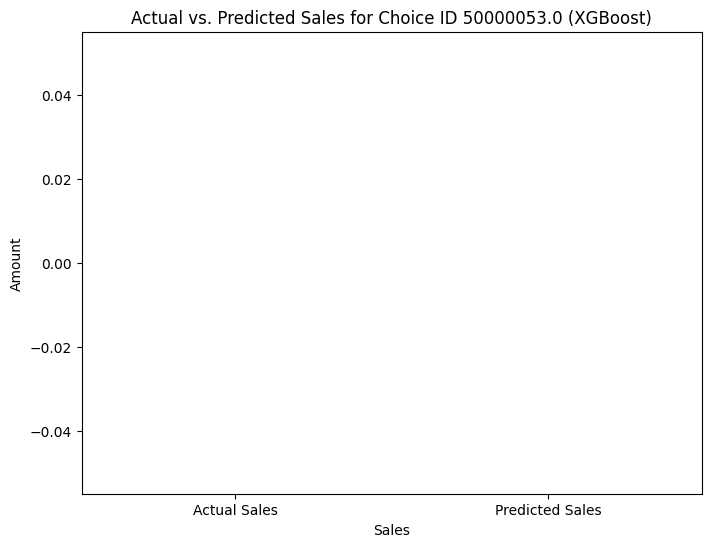

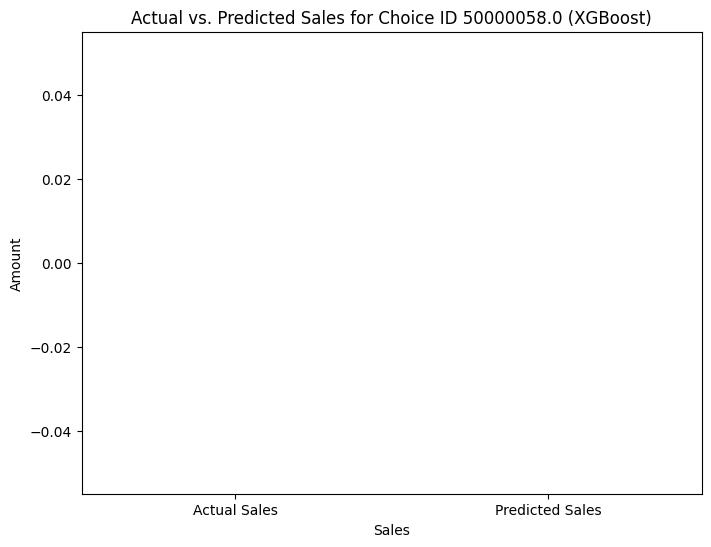

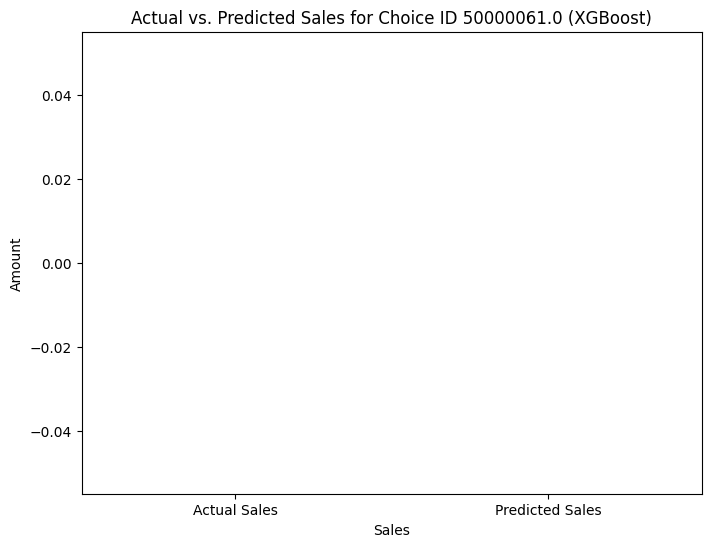

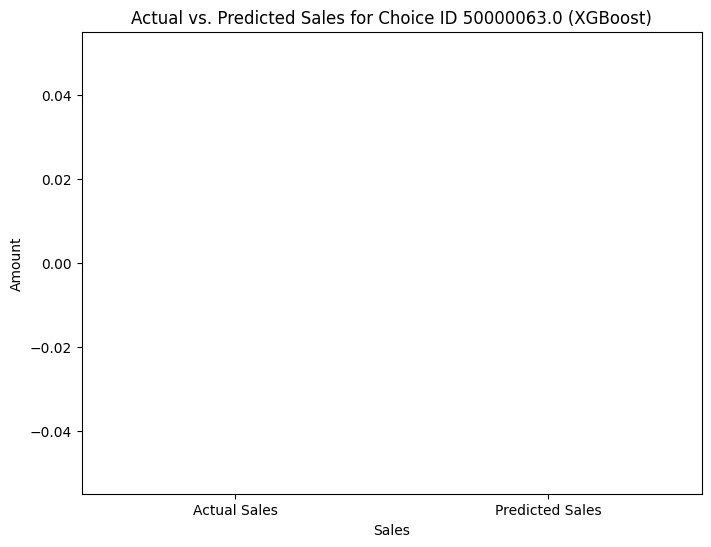

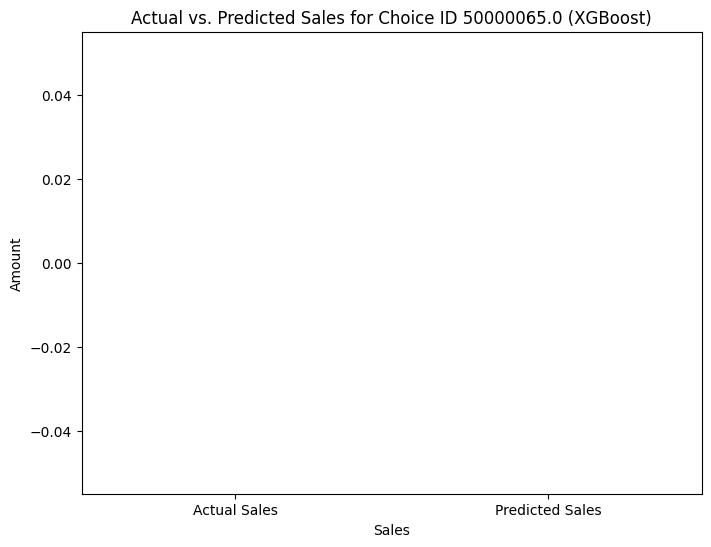

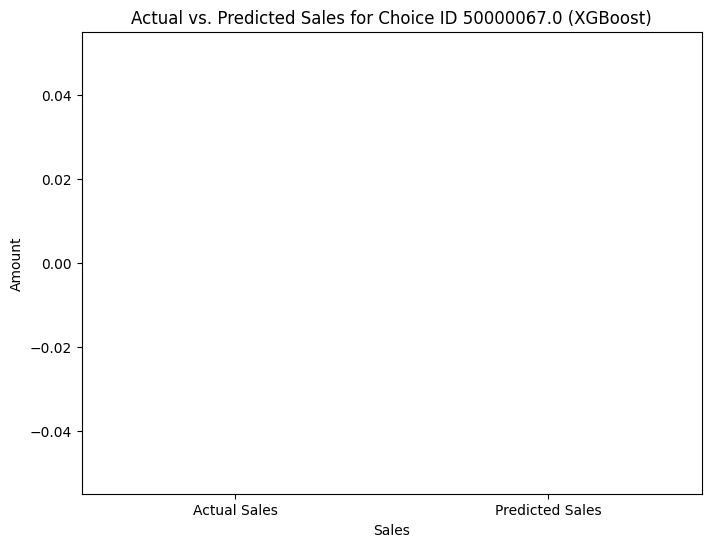

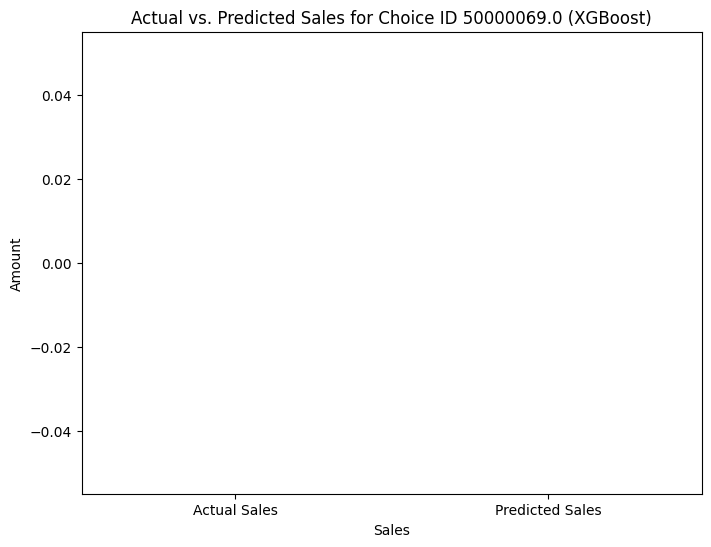

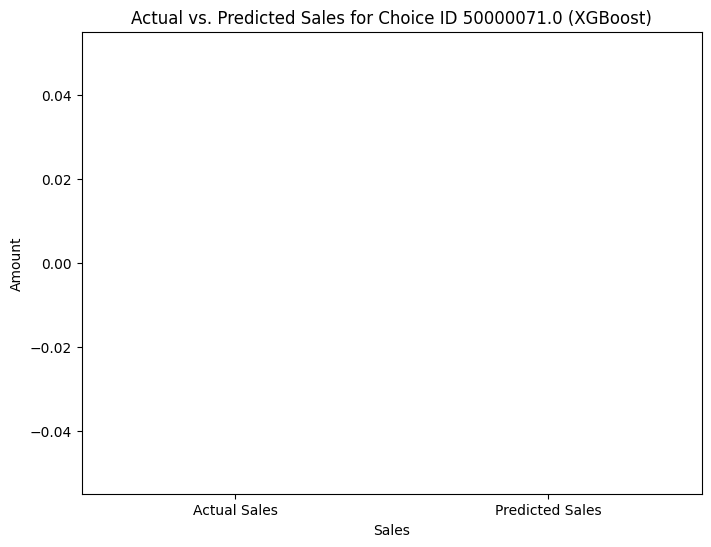

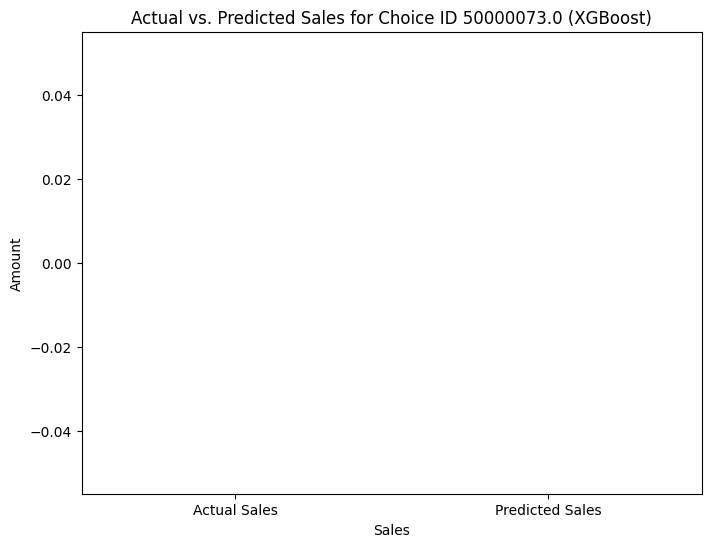

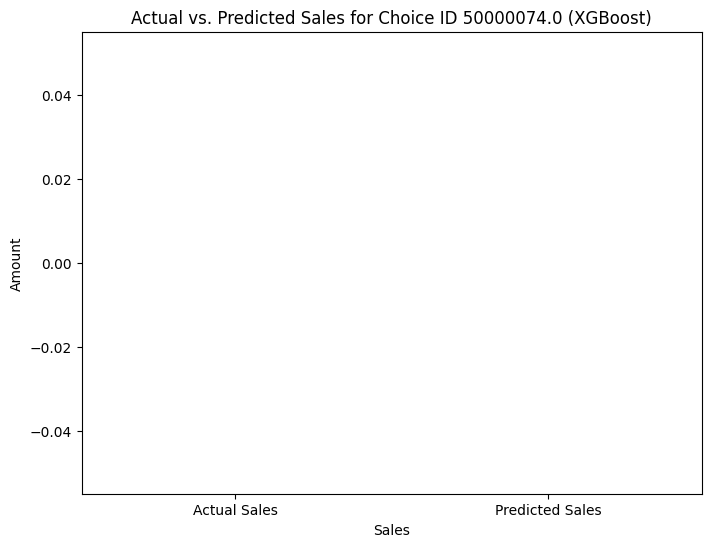

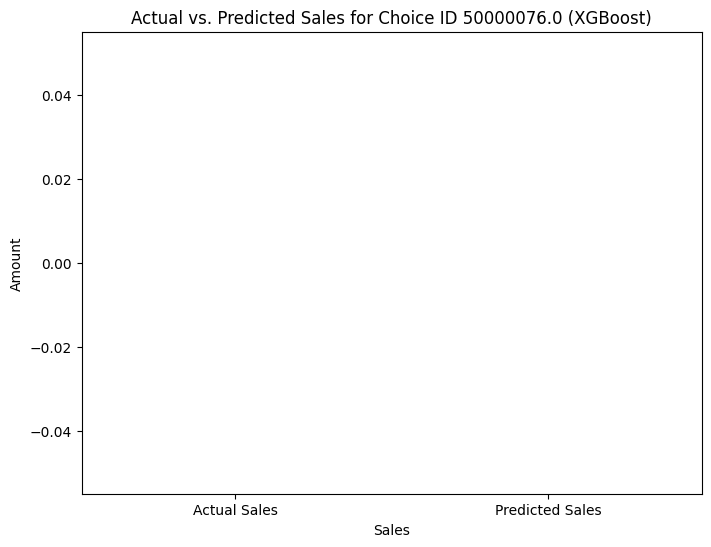

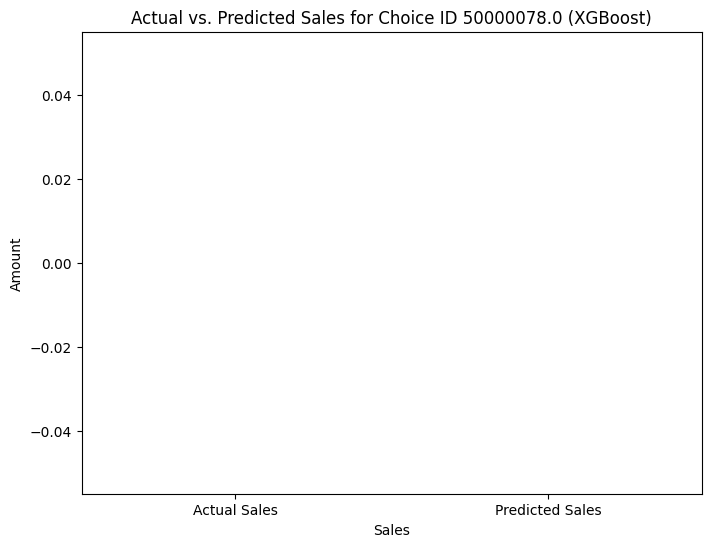

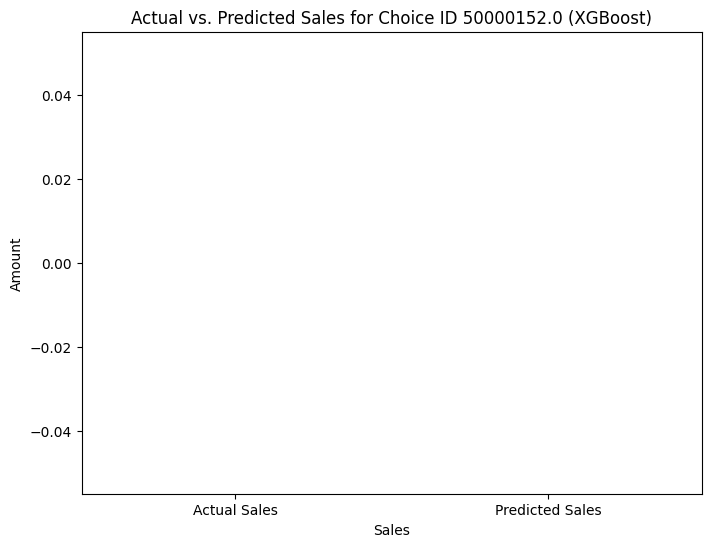

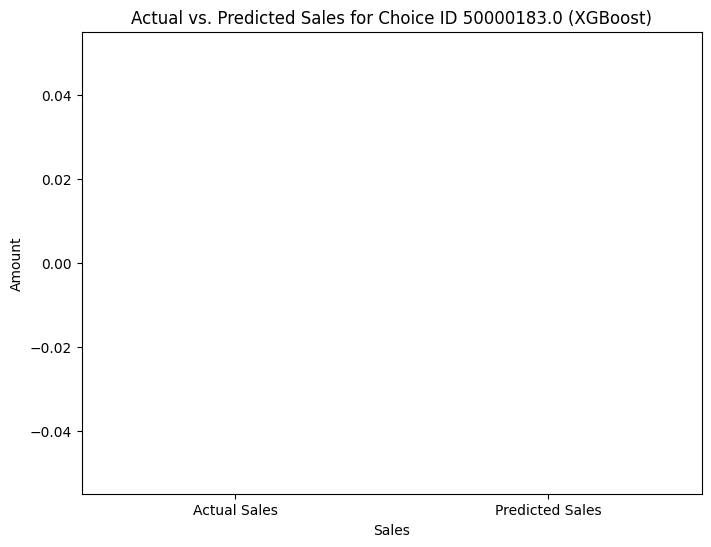

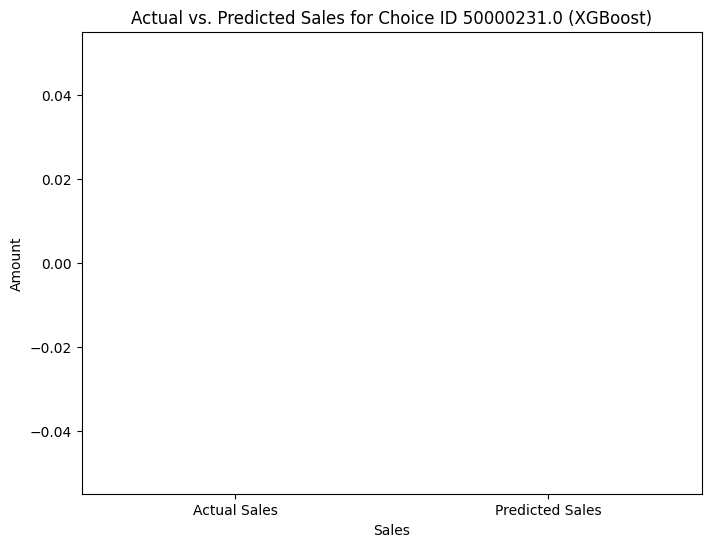

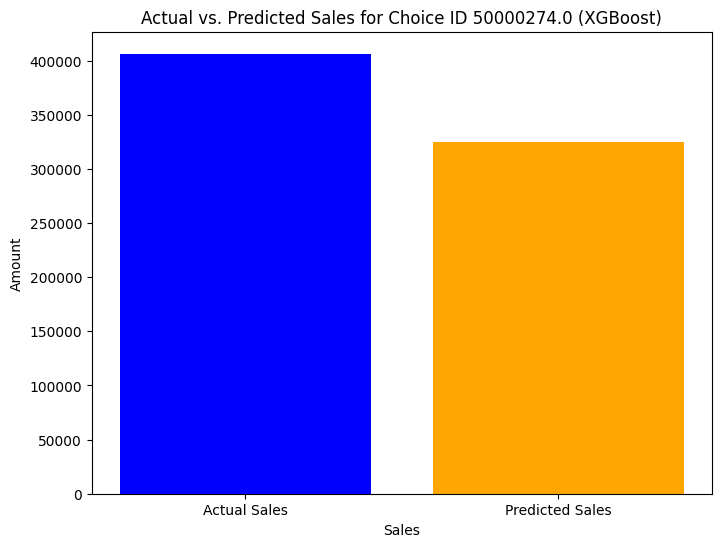

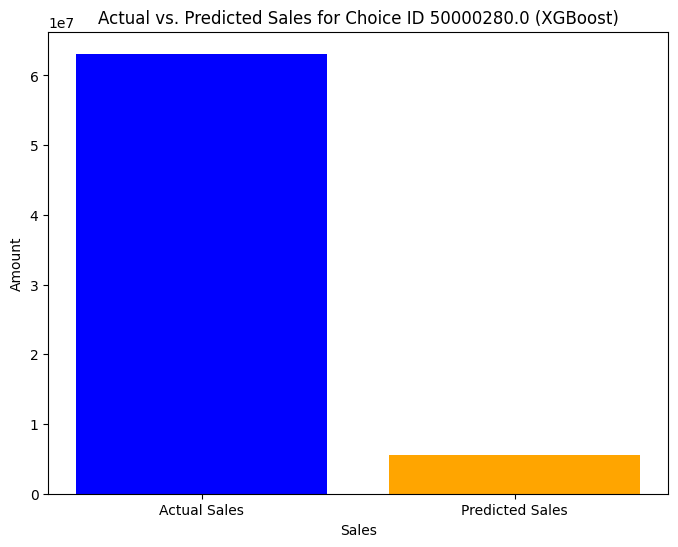

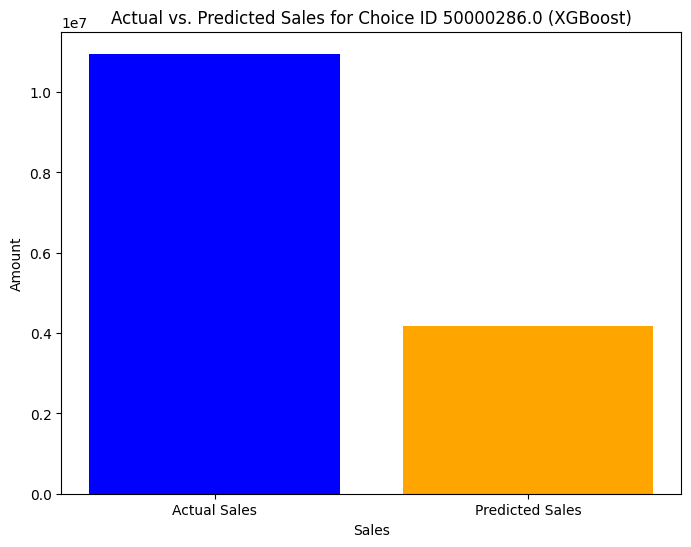

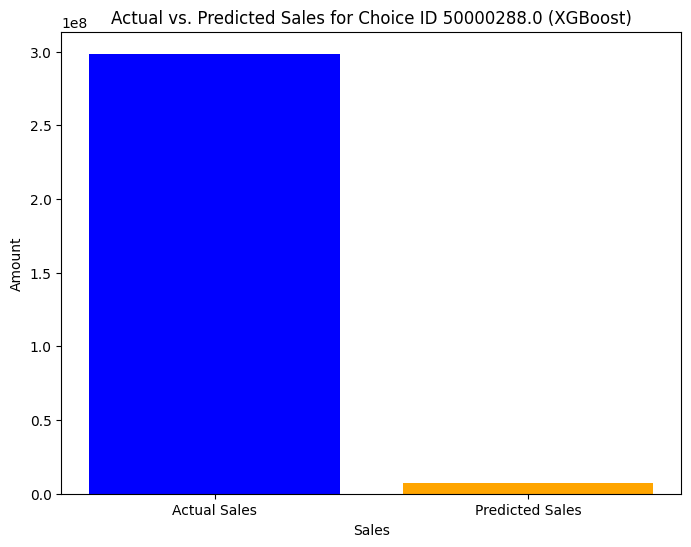

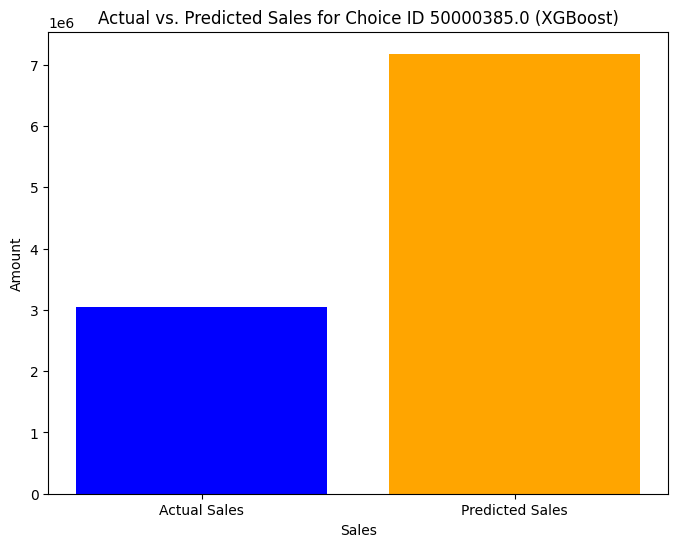

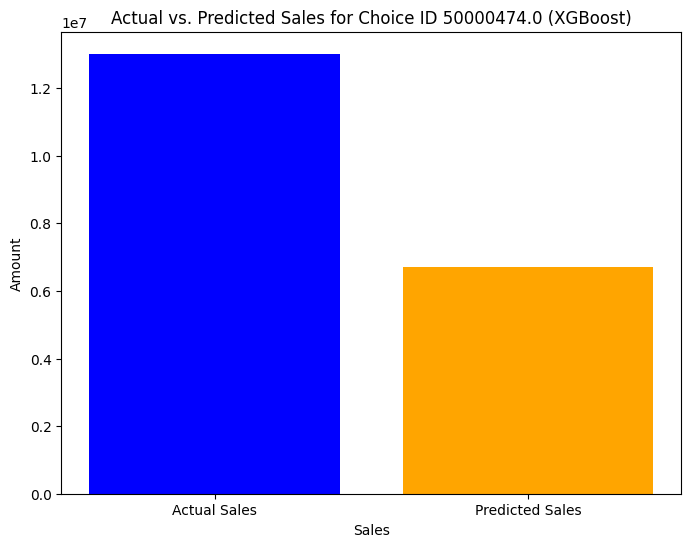

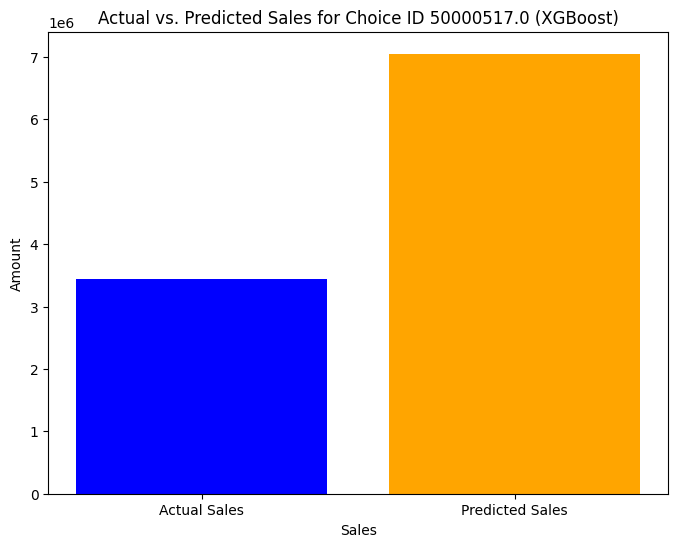

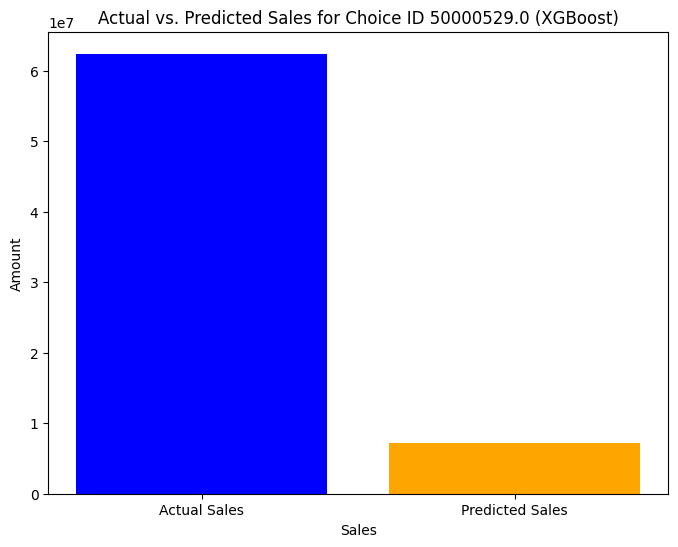

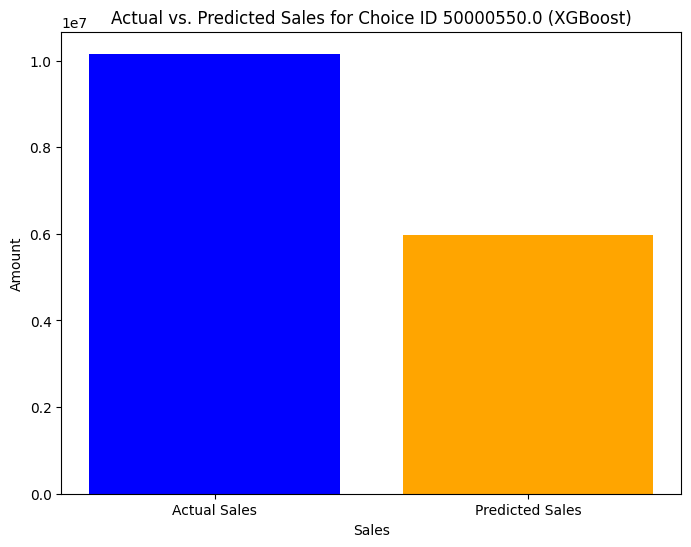

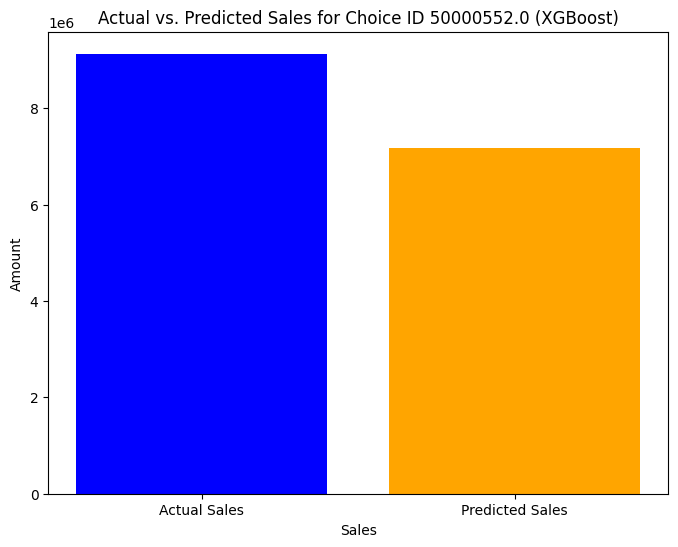

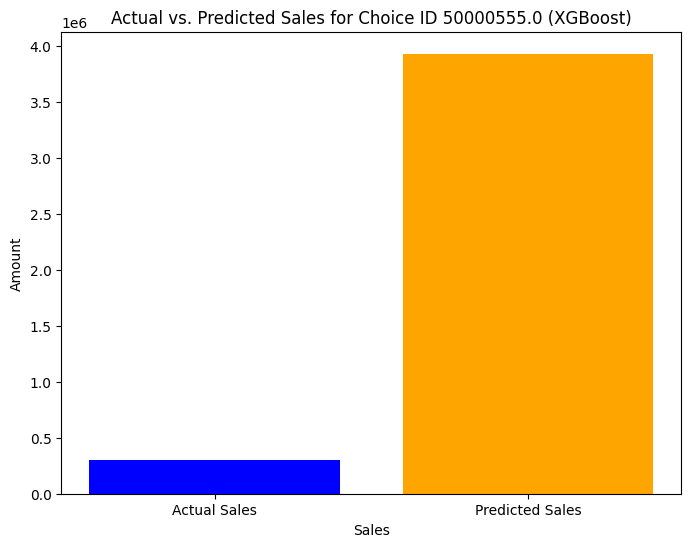

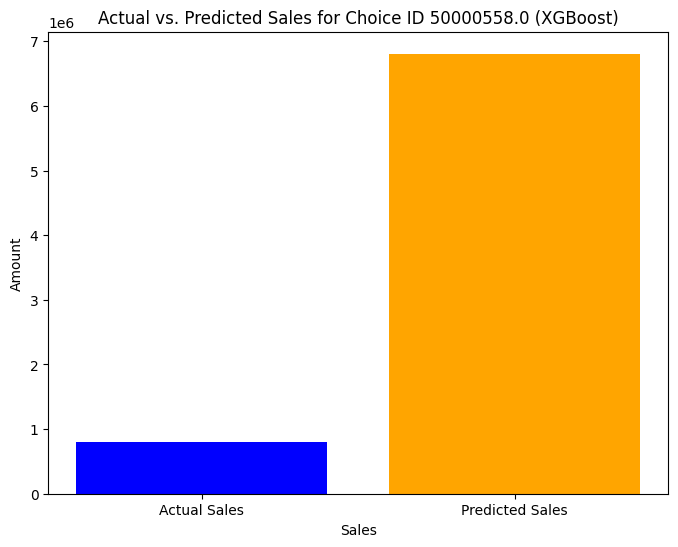

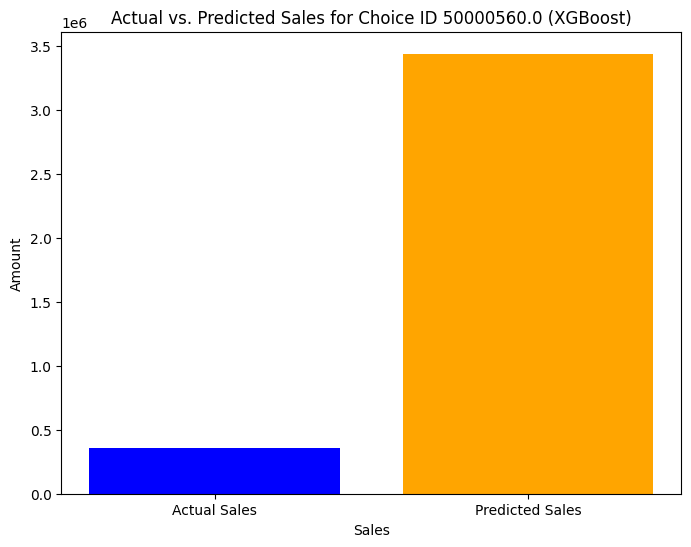

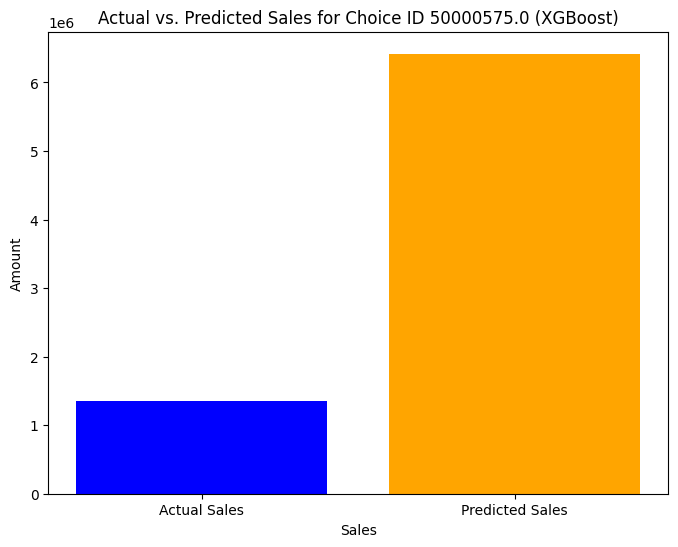

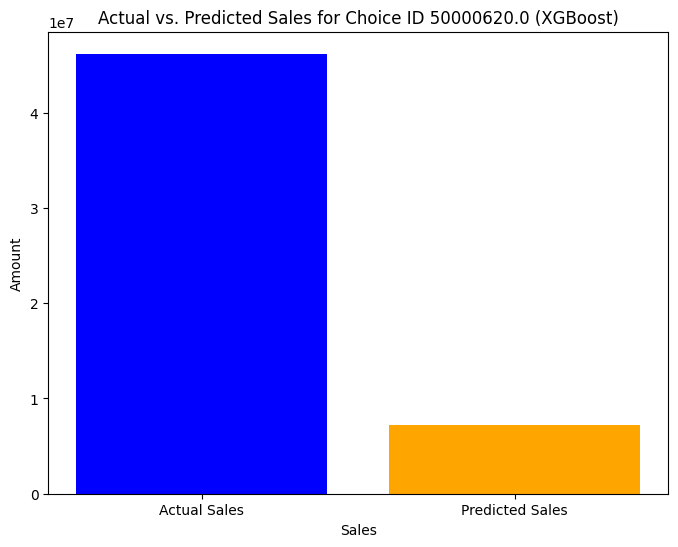

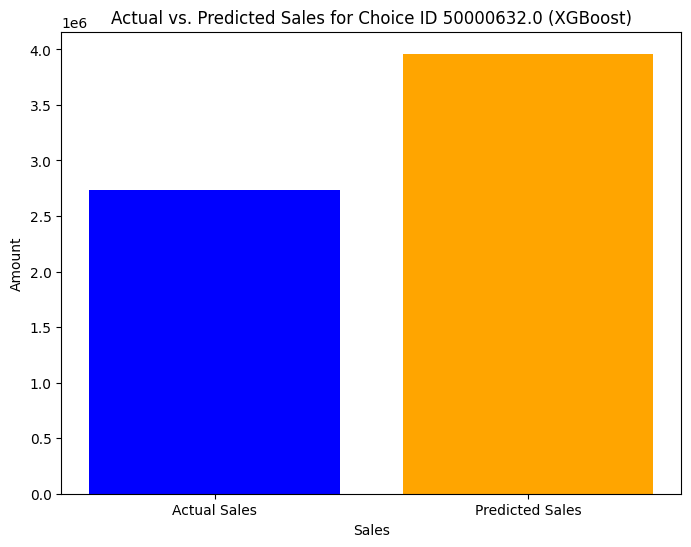

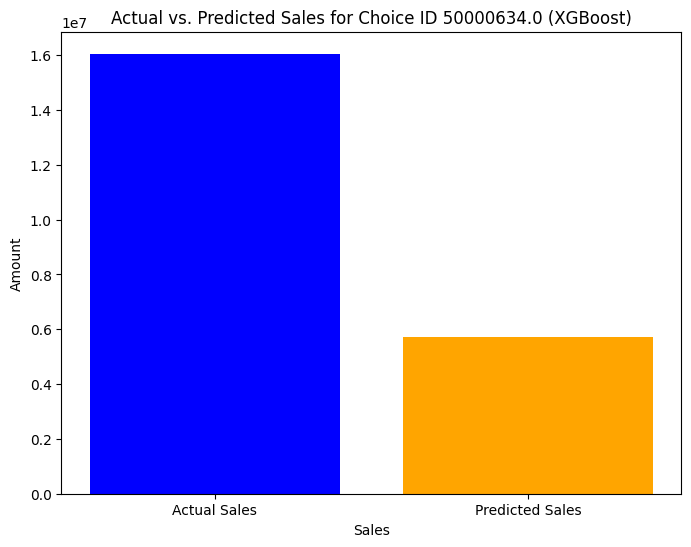

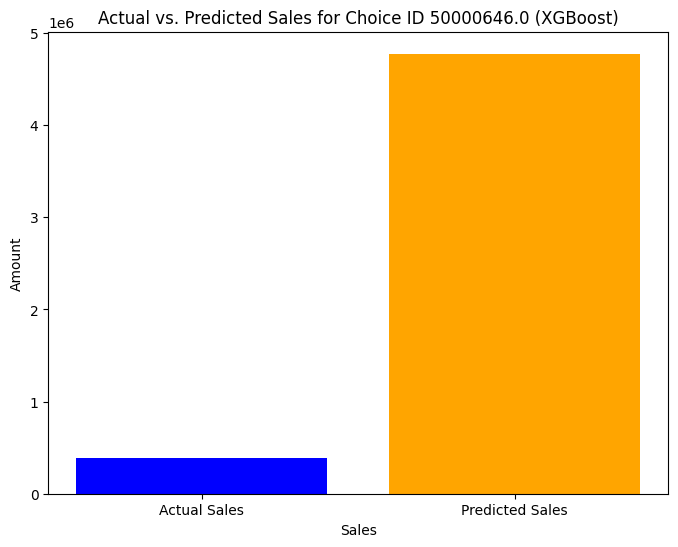

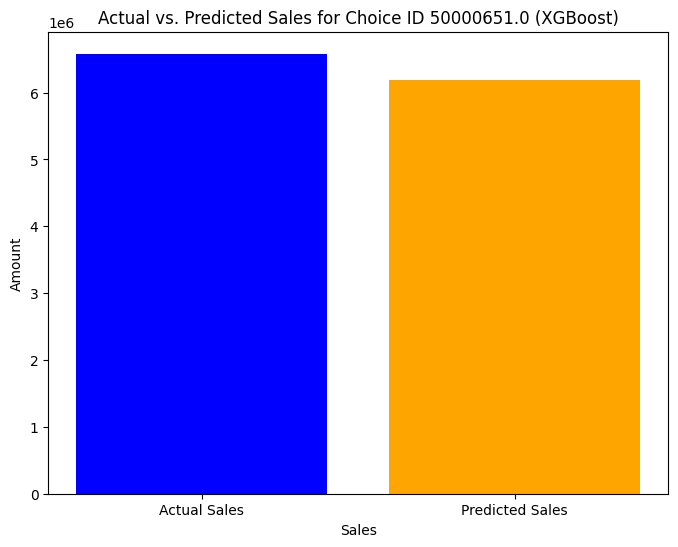

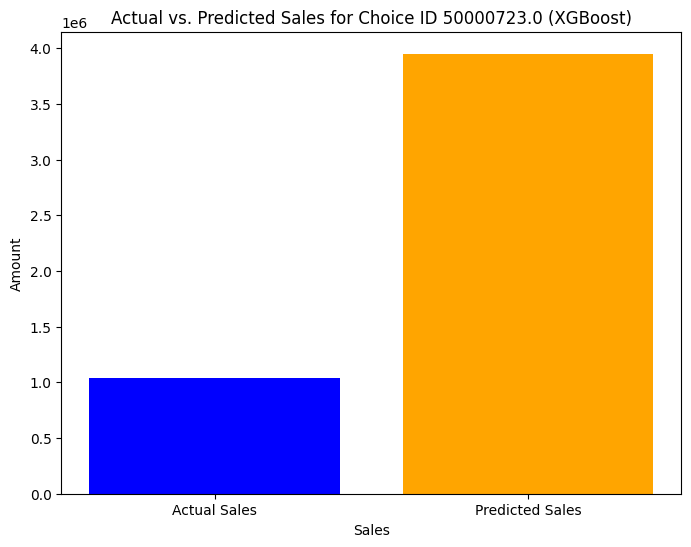

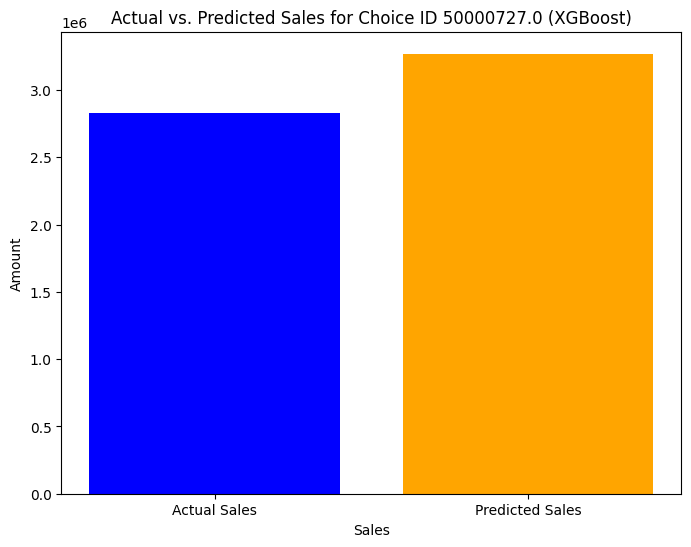

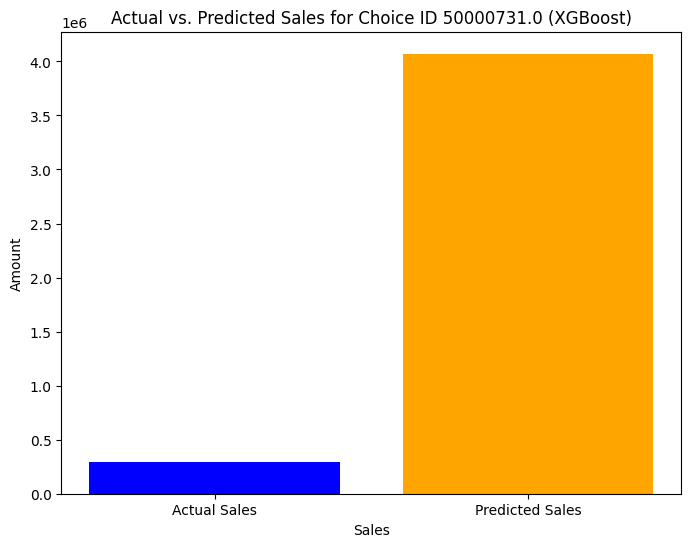

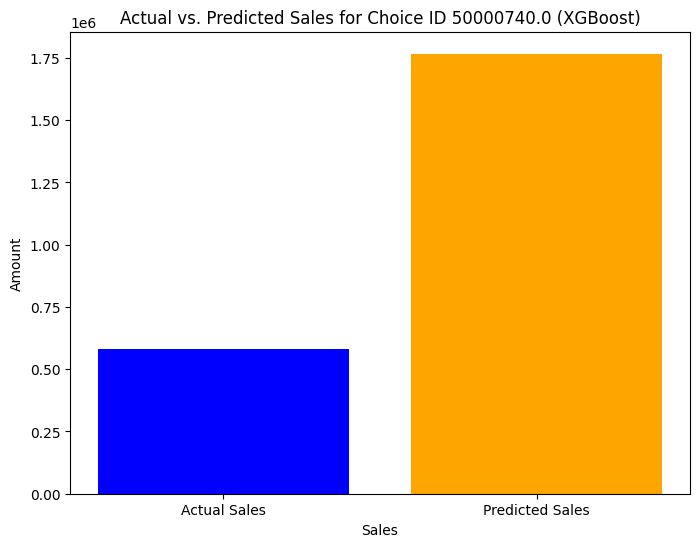

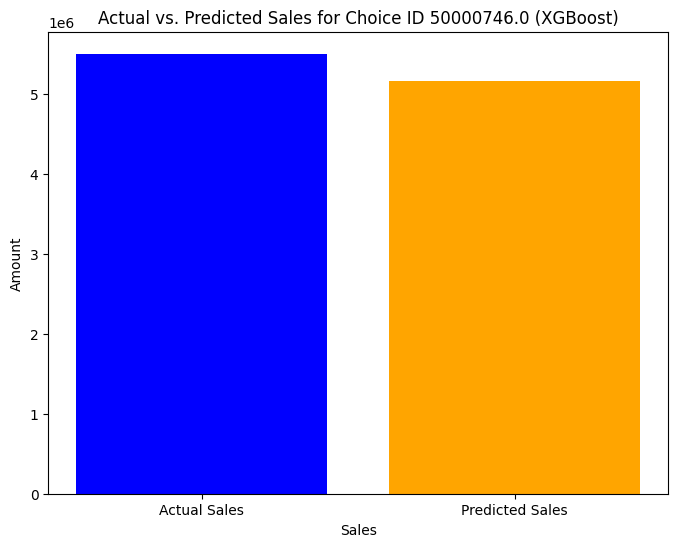

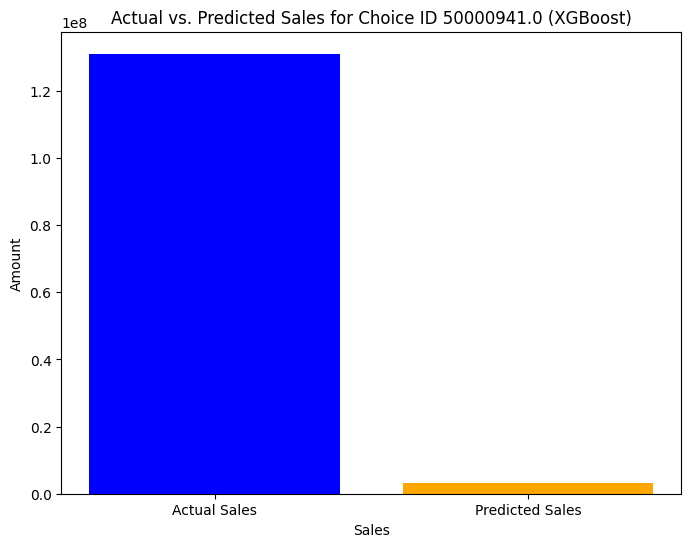

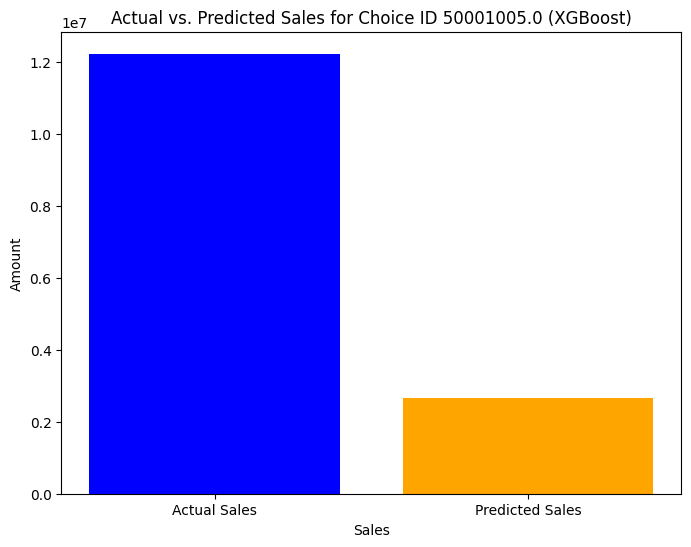

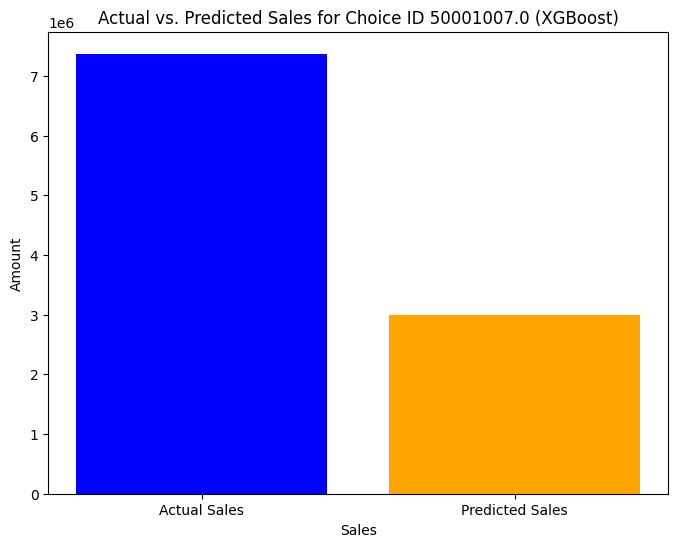

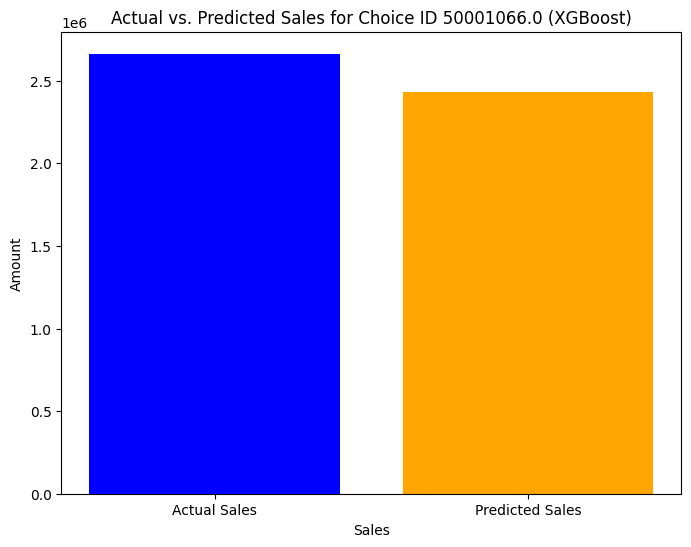

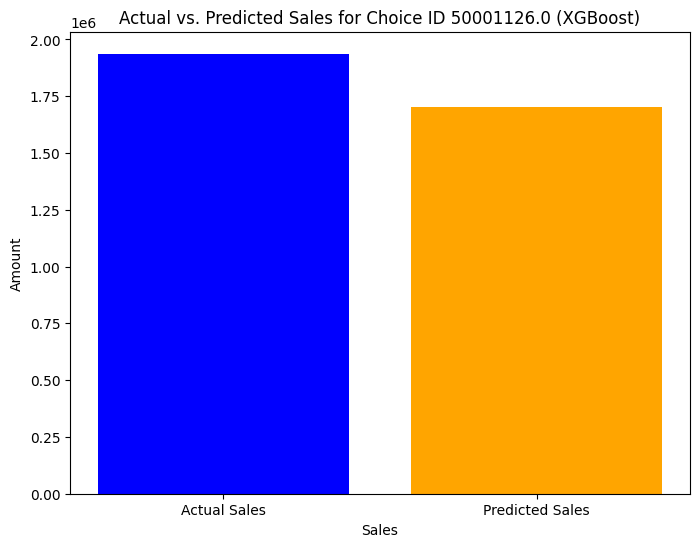

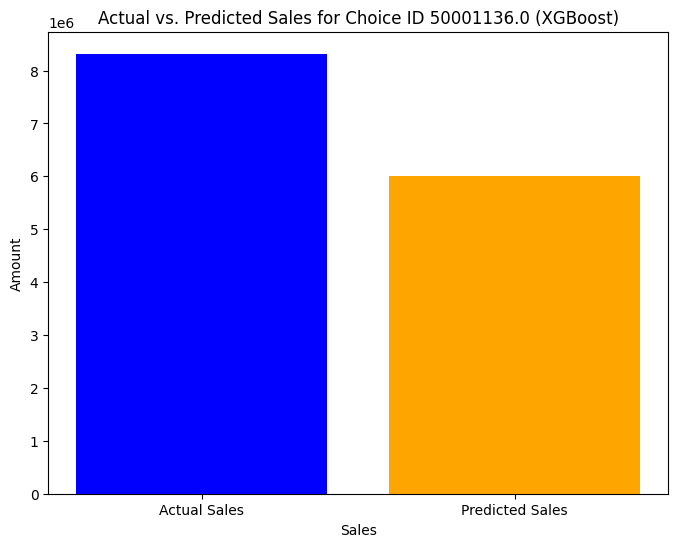

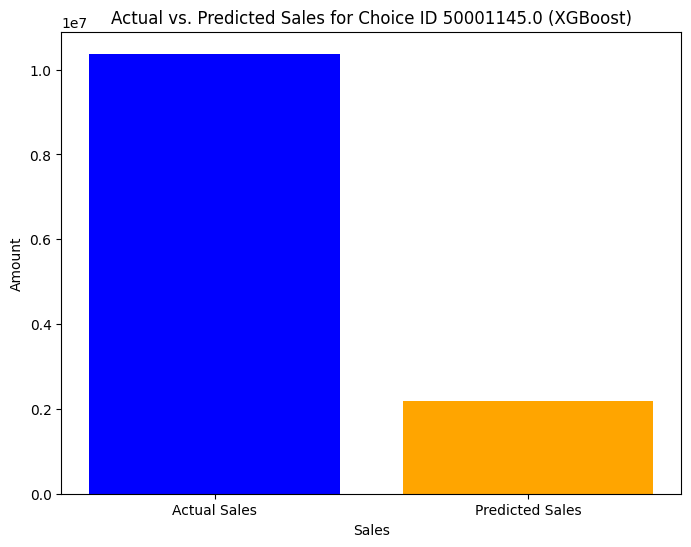

In [ ]:
def plot_sales(predictions_agg, model_name):
    for idx, row in predictions_agg.iterrows():
        PTNR_REGIONAL_MASTER_CD = row['PTNR_REGIONAL_MASTER_CD']
        actual_sales = row['Actual_Sales']
        predicted_sales = row['Predicted_Sales']

        plt.figure(figsize=(8, 6))
        plt.bar(['Actual Sales', 'Predicted Sales'], [actual_sales, predicted_sales], color=['blue', 'orange'])
        plt.title(f'Actual vs. Predicted Sales for Choice ID {PTNR_REGIONAL_MASTER_CD} ({model_name})')
        plt.xlabel('Sales')
        plt.ylabel('Amount')
        plt.show()

# Plotting for XGBoost
plot_sales(predictions_agg_xgb, 'XGBoost')

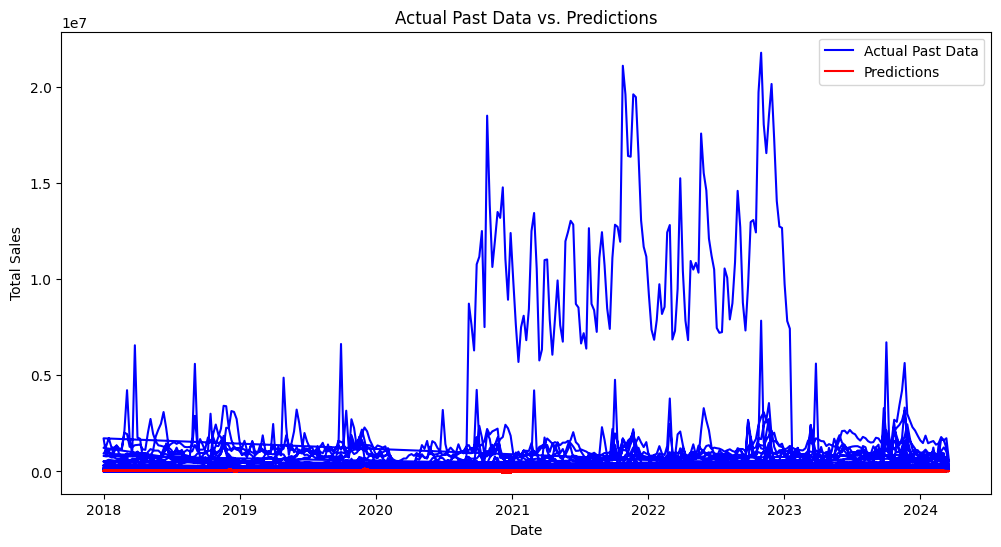

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['TOTAL_SALES'], label='Actual Past Data', color='blue')
plt.plot(test.index, y_pred_test, label='Predictions', color='red')
plt.title('Actual Past Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [ ]:
rmse

280596.28342550946